# Deep learning: ResNet vs ResNet-50

By Zhu Xiaochen (A0194512H)

In this notebook, we briefly demonstrate the superiority of ResNet-50 over simpler residual networks.
There are two main differences between them:
1. ResNet-50 is a more complicated model.
2. ResNet-50 has pre-trained weights from ImageNet.

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

## Retrieve Dataset

In [2]:
train_ds = tfds.load("deep_weeds", with_info=False, split='train[0%:80%]')
test_ds  = tfds.load("deep_weeds", with_info=False, split='train[80%:100%]')

## Constructing the train and test datasets

In [3]:
def preprocess(image, label):
  processed_image = image / 255
  processed_label = label
  return processed_image, processed_label

def augment(image, label):
    '''
    this augmentor simulates the series of augmentation made in the paper!
    + random rotation
    +
    '''
    # image = zoom([image])
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.5)
    # random hoeizontal flip
    image = tf.image.random_flip_left_right(image)
    # random vertical flip
    image = tf.image.random_flip_up_down(image)
    # random shiffting of the channels
    image = tf.image.random_hue(image, max_delta=0.1)
    # Adjust contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    #random rotation
    delta = tf.random.uniform([], minval = math.radians(-360), maxval = math.radians(360), dtype=tf.float32)
    image = tf.image.rot90(image, tf.dtypes.cast(delta, tf.int32))
    # random zoom hack 
    # since the image is 224x224 px we gonna crop it randomly between 70~200 px
    # crop_size = tf.random.uniform([], minval = 112 ,maxval = 224, dtype=tf.float32) #generate random crop size
    # image = tf.image.random_crop(image, [crop_size,crop_size,3], seed=0, name=None)
    # image = tf.image.resize(image, [224,224], method = tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,antialias=False, name=None)
    return image, label

# Use the batch method to prepare batches.
processed_train_ds = (train_ds
                .map(preprocess)
                .map(lambda x, y: (data_augmentation(x, training=True), y))
                .cache()
                .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(32)
                .prefetch(tf.data.experimental.AUTOTUNE))

processed_test_ds = test_ds.map(preprocess).cache().batch(32)
# data_test_gen = data_test.map(preprocess_scale_resize).cache().batch(32)

## A ResNet with fewer layers

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # for size in [64, 128]:
    for size in [64, 64, 128, 128, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(256,256,3), num_classes=9)

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [35]:
LOG = model.fit(x=processed_train_ds,
          epochs=50,
          batch_size=32,
          validation_data=processed_test_ds,)

Epoch 1/50
10/10 [==============================] - 19s 779ms/step - loss: 3.8799 - accuracy: 0.1333 - val_loss: 79.4651 - val_accuracy: 0.0933
Epoch 2/50
10/10 [==============================] - 4s 395ms/step - loss: 2.8858 - accuracy: 0.1533 - val_loss: 44.4349 - val_accuracy: 0.1200
Epoch 3/50
10/10 [==============================] - 4s 393ms/step - loss: 2.5745 - accuracy: 0.2167 - val_loss: 22.7156 - val_accuracy: 0.0933
Epoch 4/50
10/10 [==============================] - 4s 393ms/step - loss: 2.1695 - accuracy: 0.2600 - val_loss: 5.9721 - val_accuracy: 0.1067
Epoch 5/50
10/10 [==============================] - 4s 389ms/step - loss: 2.1351 - accuracy: 0.2600 - val_loss: 4.5413 - val_accuracy: 0.0667
Epoch 6/50
10/10 [==============================] - 4s 391ms/step - loss: 2.0008 - accuracy: 0.2733 - val_loss: 3.1943 - val_accuracy: 0.1200
Epoch 7/50
10/10 [==============================] - 4s 391ms/step - loss: 1.9790 - accuracy: 0.2933 - val_loss: 2.7706 - val_accuracy: 0.1600
Ep

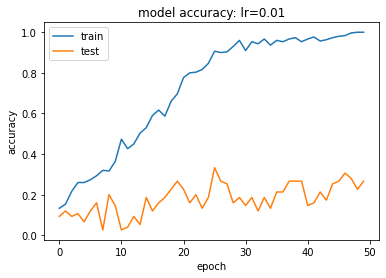

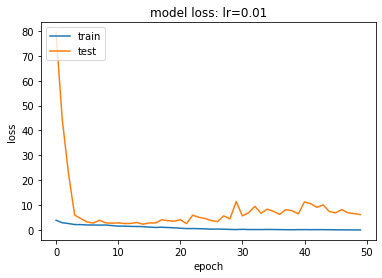

In [38]:
plt.plot(LOG.history['accuracy'])
plt.plot(LOG.history['val_accuracy'])
plt.title('model accuracy: lr=0.01')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(LOG.history['loss'])
plt.plot(LOG.history['val_loss'])
plt.title('model loss: lr=0.01')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Train with `RetNet50`

In [3]:
import math

# def preprocess_and_scale(image, label):
#   processed_image = tf.image.resize(image, [224, 224]) / 255
#   processed_label = label
#   return processed_image, processed_label

def preprocess_and_scale(dict):
  processed_image = tf.image.resize(dict['image'], [224, 224]) / 255
  processed_label = dict['label']
  return processed_image, processed_label

def augment(image, label):
    '''
    this augmentor simulates the series of augmentation made in the paper!
    + random rotation
    +
    '''

    # image = zoom([image])
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.5)
    # random hoeizontal flip
    image = tf.image.random_flip_left_right(image)
    # random vertical flip
    image = tf.image.random_flip_up_down(image)
    # random shiffting of the channels
    image = tf.image.random_hue(image, max_delta=0.1)
    # Adjust contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    #random rotation
    delta = tf.random.uniform([], minval = math.radians(-360), maxval = math.radians(360), dtype=tf.float32)
    image = tf.image.rot90(image, tf.dtypes.cast(delta, tf.int32))
    # random zoom hack 
    # since the image is 224x224 px we gonna crop it randomly between 70~200 px
    # crop_size = tf.random.uniform([], minval = 112 ,maxval = 224, dtype=tf.float32) #generate random crop size
    # image = tf.image.random_crop(image, [crop_size,crop_size,3], seed=0, name=None)
    # image = tf.image.resize(image, [224,224], method = tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,antialias=False, name=None)
    return image, label

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# Use the batch method to prepare batches.
scaled_train_ds = (train_ds
                .map(preprocess_and_scale)
                # .map(lambda x, y: (data_augmentation(x, training=True), y))
                .cache()
                .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(32)
                .prefetch(tf.data.experimental.AUTOTUNE))

scaled_test_ds = test_ds.map(preprocess_and_scale).cache().batch(32)

In [4]:
from tensorflow.keras.applications import ResNet50

INITIAL_LR = 0.001
NUM_CLASSES = 9

image_input = layers.Input((224, 224, 3))
resnet = ResNet50(include_top=False, weights="imagenet")

model = tf.keras.Sequential(
        [image_input,
        resnet,
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES, activation="softmax")])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss="sparse_categorical_crossentropy", metrics="accuracy")

In [5]:
log_50 = model.fit(x=scaled_train_ds, epochs=10, batch_size=32, validation_data=scaled_test_ds,)

Epoch 1/10
438/438 [==============================] - 169s 365ms/step - loss: 1.2050 - accuracy: 0.5994 - val_loss: 4.7061 - val_accuracy: 0.0603
Epoch 2/10
438/438 [==============================] - 157s 358ms/step - loss: 0.7982 - accuracy: 0.7201 - val_loss: 2.6577 - val_accuracy: 0.1839
Epoch 3/10
438/438 [==============================] - 157s 358ms/step - loss: 0.6844 - accuracy: 0.7616 - val_loss: 0.8134 - val_accuracy: 0.7242
Epoch 4/10
438/438 [==============================] - 231s 528ms/step - loss: 0.5819 - accuracy: 0.7955 - val_loss: 1.3527 - val_accuracy: 0.6128
Epoch 5/10
438/438 [==============================] - 300s 684ms/step - loss: 0.5195 - accuracy: 0.8202 - val_loss: 0.6049 - val_accuracy: 0.7958
Epoch 6/10
438/438 [==============================] - 294s 671ms/step - loss: 0.4896 - accuracy: 0.8293 - val_loss: 1.0262 - val_accuracy: 0.6668
Epoch 7/10
438/438 [==============================] - 294s 670ms/step - loss: 0.4455 - accuracy: 0.8455 - val_loss: 1.5437 -

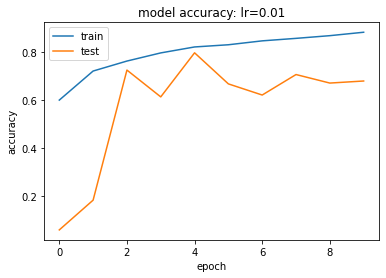

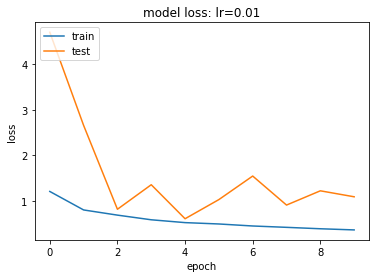

In [6]:
plt.plot(log_50.history['accuracy'])
plt.plot(log_50.history['val_accuracy'])
plt.title('model accuracy: lr=0.01')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(log_50.history['loss'])
plt.plot(log_50.history['val_loss'])
plt.title('model loss: lr=0.01')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()